In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import math
from keras.applications import vgg16
import matplotlib.cm as cm

In [4]:
model = vgg16.VGG16(weights='imagenet')

Metal device set to: Apple M1


2021-10-02 13:00:27.600579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-02 13:00:27.600922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


553476096/553467096 [==============================] - 105s 0us/step


In [106]:
model.layers[-1].activation = None

In [167]:
layer_name = 'block5_pool'

In [144]:
def get_image(path):
    img = keras.preprocessing.image.load_img(path , target_size=(224,224))
    img = keras.preprocessing.image.img_to_array(img)
    img = img[np.newaxis,...]
    img = vgg16.preprocess_input(img)
    return img

def grads(layer_name,img,pred_index=None):
    extractor = keras.Model([model.inputs],[model.get_layer(layer_name).output,model.output])
    
    with tf.GradientTape() as tape:
        layer_output , output = extractor(img)
        if pred_index is None:
            pred_index = np.argmax(output[0])
        output = output[:,pred_index]
        
    grad = tape.gradient(output,layer_output)
    grad = tf.reduce_mean(grad,axis=(0,1,2))
    
    layer_output = layer_output[0]
    layer_output = layer_output @ grad[...,np.newaxis]
    layer_output = np.squeeze(layer_output)
    layer_output = tf.maximum(layer_output,0) / tf.math.reduce_max(layer_output)
    
    return layer_output

def show_merged(img,layer_name,pred_index=None,alpha=0.4):
    heatmap = grads(layer_name,img,pred_index)
    heatmap = np.uint(heatmap*255)
    
    jet = cm.get_cmap('jet')
    
    jet_colours = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colours[heatmap]
    
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superImposed = jet_heatmap*alpha + img
    superImposed = keras.preprocessing.image.array_to_img(superImposed[0])
    return superImposed

In [179]:
out = show_merged(get_image('ele.png'),'block5_pool',alpha=0.4)

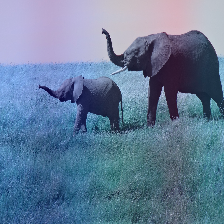

In [180]:
out

In [158]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     